In [ ]:
import gdown

train_file_id = "1pe4_HgXb9dctFGJXVNlyNcKSXZeht0lX&export=download&authuser=0&confirm=t&uuid=b95b4297-9c61-42f8-a501-4d62f585546c&at=AN_67v3oaLEb9cS4k8wNadaTebci%3A1729526518538"
download_url = "https://drive.google.com/uc?id={}".format(train_file_id)
gdown.download(download_url, quiet=False)

In [ ]:
validation_file_id = "1hwz6X-Zp7JpJL35K6P3z7k6O_PTXhUcT&export=download&authuser=0"
download_url = "https://drive.google.com/uc?id={}".format(validation_file_id)
gdown.download(download_url, quiet=False)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### 1.Preparing Train Dataset

In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/car_img-test.zip', 'r') as file:
    file.extractall('train_dataset')

In [3]:
with zipfile.ZipFile('/content/drive/MyDrive/car_img-validation.zip', 'r') as file:
    file.extractall('validation_dataset')

In [4]:
import os

train_folder = 'train_dataset/train/'
image_files = [f for f in os.listdir(train_folder) if f.endswith(('png', 'jpg', 'jpeg'))]

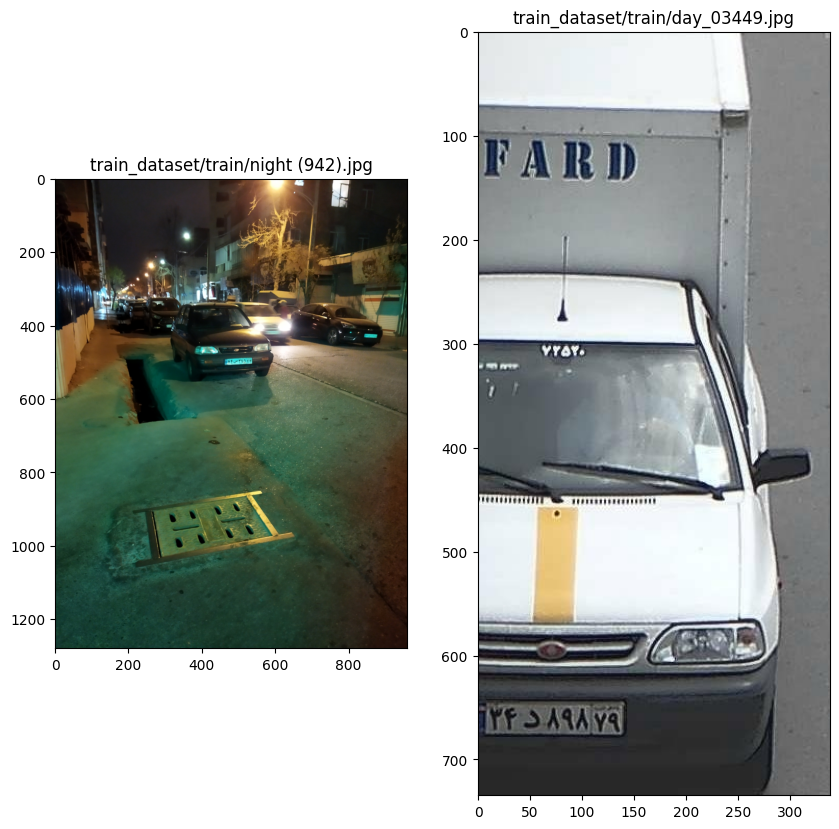

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(2):
    path = os.path.join(train_folder, image_files[i])
    img = plt.imread(path)

    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.title(path)

plt.show()

In [6]:
len(image_files)

4176

### Separate images taken in day

In [7]:
image_files = [t for t in image_files if t.startswith('day')]
len(image_files)

3351

### Separate Train Labels related to images in day

In [8]:
label_files = ['{}.xml'.format(t.split('.')[0]) for t in image_files]
len(label_files)

3351

In [9]:
from bs4 import BeautifulSoup


def calc_plate_area(plate_info):
    xmax = int(plate_info.find('xmax').text)
    xmin = int(plate_info.find('xmin').text)
    ymax = int(plate_info.find('ymax').text)
    ymin = int(plate_info.find('ymin').text)

    return (xmax - xmin) * (ymax - ymin)


def extract_plate_numbers(label_file):
    plate_char_num = 8

    file = open(label_file)
    content = file.read()
    bs_data = BeautifulSoup(content, 'xml')

    plate_numbers = list(filter(lambda tag: tag.text != 'کل ناحیه پلاک', bs_data.find_all('name')))
    plate_numbers = list(map(lambda tag: tag.text, plate_numbers))
    plate_numbers = [plate_numbers[i: i + plate_char_num] for i in range(0, len(plate_numbers), plate_char_num)]

    file.close()

    return plate_numbers


def extract_plate_coordinates(label_file):
    file = open(label_file)
    content = file.read()
    bs_data = BeautifulSoup(content, 'xml')

    matches = list(filter(lambda t: t.find('name').text == 'کل ناحیه پلاک', bs_data.find_all('object')))
    plate = max(matches, key = lambda p: calc_plate_area(p))
    plate = [int(plate.find('xmax').text), int(plate.find('xmin').text), int(plate.find('ymax').text), int(plate.find('ymin').text)]

    file.close()

    return plate

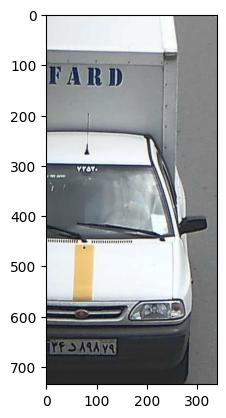

In [10]:
plt.imshow(plt.imread(train_folder + image_files[0]))

In [11]:
extract_plate_numbers(os.path.join(train_folder, label_files[0]))

[['3', '4', 'د', '8', '9', '8', '7', '9']]

In [12]:
extract_plate_coordinates(os.path.join(train_folder, label_files[0]))

[142, 3, 678, 646]

### Converting all xml content to plate coordinates

In [13]:
train_labels = []

for i in range(len(label_files)):
    plate = extract_plate_coordinates(os.path.join(train_folder, label_files[i]))
    train_labels.append((label_files[i],plate))

### Normalizing data for adjusting brightness on train and validation data(in HSV dim)

In [14]:
import cv2

# Define folders
input_folder = '/content/train_dataset/train'
output_folder = '/content/train_dataset/train_normalized_image'
os.makedirs(output_folder, exist_ok=True)

def normalize_hsv(img):
    # Convert to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Separate the HSV channels
    h, s, v = cv2.split(hsv_img)

    # Normalize the Value channel
    v = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)

    # Merge back the channels
    normalized_img = cv2.merge([h, s, v])

    # Convert back to RGB
    normalized_img = cv2.cvtColor(normalized_img, cv2.COLOR_HSV2RGB)

    return normalized_img

# Process and save each image
for filename in os.listdir(input_folder):
    if filename.endswith('.jpg'):
        img_path = os.path.join(input_folder, filename)

        # Load image and convert to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Normalize image
        img_normalized = normalize_hsv(img)

        # Convert back to uint8 for saving
        img_normalized = img_normalized.astype('uint8')

        # Save processed image
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, cv2.cvtColor(img_normalized, cv2.COLOR_RGB2BGR))

print("Images have been normalized and saved in the 'train_dataset/train_normalized_image' folder.")

Images have been normalized and saved in the 'train_dataset/train_normalized_image' folder.


In [15]:
# Define folders
input_folder = '/content/validation_dataset/validation'
output_folder = '/content/validation_dataset/validation_normalized_image'
os.makedirs(output_folder, exist_ok=True)


# Process and save each image
for filename in os.listdir(input_folder):
    if filename.endswith('.jpg'):
        img_path = os.path.join(input_folder, filename)

        # Load image and convert to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Normalize image
        img_normalized = normalize_hsv(img)

        # Convert back to uint8 for saving
        img_normalized = img_normalized.astype('uint8')

        # Save processed image
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, cv2.cvtColor(img_normalized, cv2.COLOR_RGB2BGR))

print("Images have been normalized and saved in the 'validation_dataset/validation_normalized_image' folder.")

Images have been normalized and saved in the 'validation_dataset/validation_normalized_image' folder.


### Converting Images to (1280, 1280, 3)(batching method)

In [16]:
#get the maximum width and height

from PIL import Image
import os

folder_path = 'train_dataset/train/'
max_width = 0
max_height = 0

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):
        img_path = os.path.join(folder_path, filename)
        with Image.open(img_path) as img:
            width, height = img.size
            max_width = max(max_width, width)
            max_height = max(max_height, height)

print("Max width (x):", max_width)
print("Max height (y):", max_height)

Max width (x): 1280
Max height (y): 1280


### using batch on train data for preventing ram overflow

In [17]:
from PIL import Image, ImageOps
import os

# Define your folder path
folder_path = 'train_dataset/train_normalized_image'
output_folder = 'train_dataset/train_resized_image'
os.makedirs(output_folder, exist_ok=True)

# Set target size
target_size = (1280, 1280)

# Define batch size (adjust this based on your memory capacity)
batch_size = 100

# List all images
images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]

# Process images in batches
for i in range(0, len(images), batch_size):
    batch = images[i:i + batch_size]

    for filename in batch:
        img_path = os.path.join(folder_path, filename)

        # Open the image
        with Image.open(img_path) as img:
            # Calculate padding values to center the image in a 1280x1280 frame
            delta_w = target_size[0] - img.width
            delta_h = target_size[1] - img.height

            # Ensure padding only on the left and bottom
            padding = (0, 0, delta_w, delta_h)

            # Add padding
            padded_img = ImageOps.expand(img, padding, fill=0)

            # Save the resized image to output folder
            output_path = os.path.join(output_folder, f'{filename}')
            padded_img.save(output_path)

    print(f'Processed batch {i // batch_size + 1} of {len(images) // batch_size + 1}')

Processed batch 1 of 42
Processed batch 2 of 42
Processed batch 3 of 42
Processed batch 4 of 42
Processed batch 5 of 42
Processed batch 6 of 42
Processed batch 7 of 42
Processed batch 8 of 42
Processed batch 9 of 42
Processed batch 10 of 42
Processed batch 11 of 42
Processed batch 12 of 42
Processed batch 13 of 42
Processed batch 14 of 42
Processed batch 15 of 42
Processed batch 16 of 42
Processed batch 17 of 42
Processed batch 18 of 42
Processed batch 19 of 42
Processed batch 20 of 42
Processed batch 21 of 42
Processed batch 22 of 42
Processed batch 23 of 42
Processed batch 24 of 42
Processed batch 25 of 42
Processed batch 26 of 42
Processed batch 27 of 42
Processed batch 28 of 42
Processed batch 29 of 42
Processed batch 30 of 42
Processed batch 31 of 42
Processed batch 32 of 42
Processed batch 33 of 42
Processed batch 34 of 42
Processed batch 35 of 42
Processed batch 36 of 42
Processed batch 37 of 42
Processed batch 38 of 42
Processed batch 39 of 42
Processed batch 40 of 42
Processed

### using batch on validation for preventing ram overflow

In [18]:
from PIL import Image, ImageOps
import os

# Define your folder path
folder_path = 'validation_dataset/validation_normalized_image'
output_folder = 'validation_dataset/validation_resized_image'
os.makedirs(output_folder, exist_ok=True)

# Set target size
target_size = (1280, 1280)

# Define batch size (adjust this based on your memory capacity)
batch_size = 100

# List all images
images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]

# Process images in batches
for i in range(0, len(images), batch_size):
    batch = images[i:i + batch_size]

    for filename in batch:
        img_path = os.path.join(folder_path, filename)

        # Open the image
        with Image.open(img_path) as img:
            # Calculate padding values to center the image in a 1280x1280 frame
            delta_w = target_size[0] - img.width
            delta_h = target_size[1] - img.height

            # Ensure padding only on the left and bottom
            padding = (0, 0, delta_w, delta_h)

            # Add padding
            padded_img = ImageOps.expand(img, padding, fill=0)

            # Save the resized image to output folder
            output_path = os.path.join(output_folder, f'{filename}')
            padded_img.save(output_path)

    print(f'Processed batch {i // batch_size + 1} of {len(images) // batch_size + 1}')

Processed batch 1 of 22
Processed batch 2 of 22
Processed batch 3 of 22
Processed batch 4 of 22
Processed batch 5 of 22
Processed batch 6 of 22
Processed batch 7 of 22
Processed batch 8 of 22
Processed batch 9 of 22
Processed batch 10 of 22
Processed batch 11 of 22
Processed batch 12 of 22
Processed batch 13 of 22
Processed batch 14 of 22
Processed batch 15 of 22
Processed batch 16 of 22
Processed batch 17 of 22
Processed batch 18 of 22
Processed batch 19 of 22
Processed batch 20 of 22
Processed batch 21 of 22
Processed batch 22 of 22


(1280, 1280, 3)


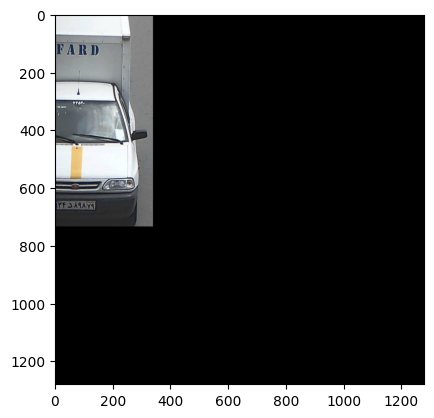

In [19]:
sample = plt.imread('train_dataset/train_resized_image/' + image_files[0])

print(sample.shape)
plt.imshow(sample)

In [20]:
extract_plate_numbers(os.path.join(train_folder, label_files[0]))

[['3', '4', 'د', '8', '9', '8', '7', '9']]

In [21]:
extract_plate_coordinates(os.path.join(train_folder, label_files[0]))

[142, 3, 678, 646]

### 2.Preparing Validation dataset

In [22]:
import os

validation_folder = 'validation_dataset/validation/'
image_files = [f for f in os.listdir(validation_folder) if f.endswith(('png', 'jpg', 'jpeg'))]

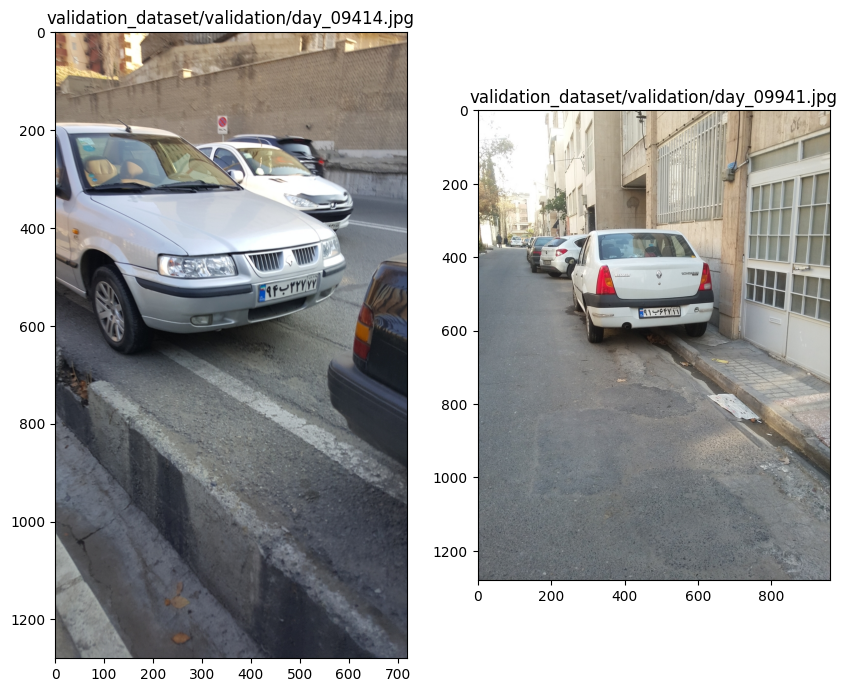

In [23]:
import os
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(2):
    path = os.path.join(validation_folder, image_files[i])
    img = plt.imread(path)

    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.title(path)

plt.show()

In [24]:
len(image_files)

2120

### Separate images taken in day

In [25]:
image_files = [t for t in image_files if t.startswith('day')]
len(image_files)

1708

### Separate Validation Labels related to images in day

In [26]:
label_files = ['{}.xml'.format(t.split('.')[0]) for t in image_files]
len(label_files)

1708

In [27]:
plt.imshow(plt.imread('validation_dataset/validation_resized_image/' + image_files[48]))

In [28]:
extract_plate_numbers(os.path.join(validation_folder, label_files[48]))

[['1', '5', 'د', '7', '9', '8', '2', '4']]

In [29]:
extract_plate_coordinates(os.path.join(validation_folder, label_files[48]))

[631, 531, 404, 379]

### Converting all xml content to plate coordinates

In [30]:
validation_labels = []

for i in range(len(label_files)):
    plate = extract_plate_coordinates(os.path.join(validation_folder, label_files[i]))
    validation_labels.append((label_files[i],plate))

### Preparaing Train and Validation Dataset for model

###Train Data

In [31]:
def generate_yolo_txt(image_width, image_height, xmin, ymin, xmax, ymax, class_id=0,directory='labels', filename='label.txt'):
  """
  Generates a YOLO format .txt file for object detection.

  Args:
    image_width: Width of the image.
    image_height: Height of the image.
    xmin: Minimum x-coordinate of the bounding box.
    ymin: Minimum y-coordinate of the bounding box.
    xmax: Maximum x-coordinate of the bounding box.
    ymax: Maximum y-coordinate of the bounding box.
    class_id: Class ID of the object.
    filename: Filename for the .txt file.
  """

  # Create the directory if it doesn't exist
  os.makedirs(directory, exist_ok=True)

  filename = filename[:-3]+'txt'
  # Construct the full file path
  file_path = os.path.join(directory, filename)

  # Calculate center x, y coordinates and width, height
  x_center = (xmin + xmax) / 2
  y_center = (ymin + ymax) / 2
  width = xmax - xmin
  height = ymax - ymin

  # Normalize coordinates to be between 0 and 1
  x_center /= image_width
  y_center /= image_height
  width /= image_width
  height /= image_height

  # Write the YOLO format line to the .txt file
  with open(file_path, 'w') as f:
    f.write(f"{class_id} {x_center} {y_center} {width} {height}")

In [32]:
train_label_dir = "/content/train_dataset/train_resized_image/labels"
for label in train_labels:
  filename = label[0]
  xmax = label[1][0]
  xmin = label[1][1]
  ymax = label[1][2]
  ymin = label[1][3]
  generate_yolo_txt(image_width=1280,image_height=1280,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,directory=train_label_dir,filename=filename)

In [33]:
import os

# Current directory where the files are located
current_dir = "/content/train_dataset/train_resized_image"

# Create two new directories if they don't exist
day_folder = os.path.join(current_dir, 'images')
night_folder = os.path.join(current_dir, 'night_images')

if not os.path.exists(day_folder):
    os.makedirs(day_folder)
if not os.path.exists(night_folder):
    os.makedirs(night_folder)

# Get list of all files in current directory
files = os.listdir(current_dir)

# Move files to respective folders
for file in files:
    # Skip if it's a directory
    if os.path.isdir(os.path.join(current_dir, file)):
        continue

    # Move files starting with 'day'
    if file.lower().startswith('day'):
        source = os.path.join(current_dir, file)
        destination = os.path.join(day_folder, file)
        os.rename(source, destination)

    # Move files starting with 'night'
    elif file.lower().startswith('night'):
        source = os.path.join(current_dir, file)
        destination = os.path.join(night_folder, file)
        os.rename(source, destination)

###Validation Data

In [34]:
validation_label_dir = "/content/validation_dataset/validation_resized_image/labels"
for label in validation_labels:
  filename = label[0]
  xmax = label[1][0]
  xmin = label[1][1]
  ymax = label[1][2]
  ymin = label[1][3]
  generate_yolo_txt(image_width=1280,image_height=1280,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,directory=validation_label_dir,filename=filename)

In [35]:
import os

# Current directory where the files are located
current_dir = "/content/validation_dataset/validation_resized_image"

# Create two new directories if they don't exist
day_folder = os.path.join(current_dir, 'images')
night_folder = os.path.join(current_dir, 'night_images')

if not os.path.exists(day_folder):
    os.makedirs(day_folder)
if not os.path.exists(night_folder):
    os.makedirs(night_folder)

# Get list of all files in current directory
files = os.listdir(current_dir)

# Move files to respective folders
for file in files:
    # Skip if it's a directory
    if os.path.isdir(os.path.join(current_dir, file)):
        continue

    # Move files starting with 'day'
    if file.lower().startswith('day'):
        source = os.path.join(current_dir, file)
        destination = os.path.join(day_folder, file)
        os.rename(source, destination)

    # Move files starting with 'night'
    elif file.lower().startswith('night'):
        source = os.path.join(current_dir, file)
        destination = os.path.join(night_folder, file)
        os.rename(source, destination)

### Creating model for training plate coordinates

In [36]:
with open("/content/data.yaml","w") as f :
  f.write('train: /content/train_dataset/train_resized_image/images\n')
  f.write('val: /content/validation_dataset/validation_resized_image/images\n')
  f.write('nc: 1\n')
  f.write('names: [license_plate]')


In [37]:
!pip install ultralytics

from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.7/877.7 kB 30.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Load a pretrained YOLOv8n model
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 286MB/s]


In [38]:
import gc # Import garbage collector for clearing memory
import torch

# Clear unused memory
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Train the model with reduced image size and batch size
results = model.train(data='/content/data.yaml',
                      epochs=100,
                      batch=-1,
                      imgsz=320,
                      save=True,
                      )

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=100, time=None, patience=100, batch=-1, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

100%|██████████| 755k/755k [00:00<00:00, 102MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 213MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=320 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.10G reserved, 0.06G allocated, 14.58G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011043       2.049         0.109         74.06         390.8        (1, 3, 320, 320)                    list
     3011043       4.097         0.126         22.25         49.78        (2, 3, 320, 320)                    list
     3011043       8.194         0.191         22.77         45.93        (4, 3, 320, 320)                    list
     3011043       16.39         0.298         25.37         48.73        (8, 3, 320, 320)                    list
     3011043       32.78         0.537         25.85         50.27       (16, 3, 320, 320)                    list
AutoBatch: Using batch-size 301 for CUDA:0 8.90G/14.75G (60%) ✅


train: Scanning /content/train_dataset/train_resized_image/labels... 3351 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3351/3351 [00:02<00:00, 1627.24it/s]


train: New cache created: /content/train_dataset/train_resized_image/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/validation_dataset/validation_resized_image/labels... 1708 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1708/1708 [00:01<00:00, 887.96it/s]


val: New cache created: /content/validation_dataset/validation_resized_image/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0023515625), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       9.4G      2.743      5.047      1.955         57        320: 100%|██████████| 12/12 [00:31<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.76s/it]


                   all       1708       1708   0.000731       0.17   0.000693   0.000343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       9.4G      1.562      2.301      1.028         49        320: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.40s/it]


                   all       1708       1708    0.00273      0.811     0.0454     0.0128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       9.4G      1.357      1.361     0.9444         50        320: 100%|██████████| 12/12 [00:31<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.41s/it]


                   all       1708       1708    0.00392      0.839      0.013    0.00675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       9.4G      1.355      1.219     0.9424         53        320: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.06s/it]


                   all       1708       1708        0.2      0.255      0.246      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       9.4G       1.28       1.11     0.9308         51        320: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.30s/it]


                   all       1708       1708      0.165     0.0981     0.0448     0.0262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       9.4G      1.344      1.097     0.9461         55        320: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.06s/it]


                   all       1708       1708       0.95      0.184      0.443      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       9.4G      1.347      1.041     0.9449         50        320: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.27s/it]


                   all       1708       1708      0.927      0.484      0.699      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       9.4G      1.336     0.9932     0.9511         61        320: 100%|██████████| 12/12 [00:33<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.06s/it]


                   all       1708       1708      0.867      0.653      0.758       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.39G      1.218      0.879     0.9257         66        320: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.05s/it]


                   all       1708       1708      0.887      0.785      0.851      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.39G      1.249     0.8511     0.9307         59        320: 100%|██████████| 12/12 [00:33<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.20s/it]


                   all       1708       1708      0.813      0.801      0.834      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.38G      1.236     0.8192     0.9297         59        320: 100%|██████████| 12/12 [00:33<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.02s/it]

                   all       1708       1708      0.871      0.848      0.877       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.38G      1.257     0.8114     0.9319         59        320: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.82s/it]

                   all       1708       1708      0.862       0.81      0.859      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.38G      1.273      0.786     0.9306         53        320: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.23s/it]

                   all       1708       1708      0.846      0.843       0.86      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.38G      1.236     0.7732     0.9319         57        320: 100%|██████████| 12/12 [00:32<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.72s/it]

                   all       1708       1708      0.847       0.84      0.876      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.38G      1.195       0.75     0.9167         67        320: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.21s/it]

                   all       1708       1708      0.843      0.871      0.872      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.38G      1.165     0.7121     0.9075         54        320: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.11s/it]

                   all       1708       1708      0.843      0.785      0.846      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.38G      1.188     0.7004     0.9199         64        320: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.81s/it]

                   all       1708       1708      0.856      0.855      0.884      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.38G      1.137      0.675     0.9114         63        320: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.09s/it]

                   all       1708       1708      0.894      0.872      0.905      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.38G      1.138     0.6696     0.9096         56        320: 100%|██████████| 12/12 [00:32<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.66s/it]

                   all       1708       1708      0.893      0.882       0.91      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.38G      1.139     0.6767     0.9132         51        320: 100%|██████████| 12/12 [00:30<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.80s/it]

                   all       1708       1708      0.891      0.846      0.893      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.38G      1.165     0.6755     0.9142         58        320: 100%|██████████| 12/12 [00:31<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.23s/it]

                   all       1708       1708      0.896      0.872      0.915      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.38G      1.116     0.6531      0.908         57        320: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.88s/it]

                   all       1708       1708      0.901      0.824      0.891      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.38G      1.147     0.6667     0.9146         49        320: 100%|██████████| 12/12 [00:32<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.18s/it]

                   all       1708       1708      0.885      0.846      0.896      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.38G      1.122     0.6576     0.9053         55        320: 100%|██████████| 12/12 [00:31<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.89s/it]

                   all       1708       1708      0.855      0.786      0.856      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.38G      1.121     0.6558     0.8996         58        320: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.05s/it]

                   all       1708       1708       0.89       0.89      0.922      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.38G      1.107     0.6444     0.9052         48        320: 100%|██████████| 12/12 [00:32<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.08s/it]

                   all       1708       1708      0.928      0.863      0.928      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.38G      1.069     0.6034     0.8957         67        320: 100%|██████████| 12/12 [00:33<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.02s/it]

                   all       1708       1708      0.907      0.882      0.928      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.38G      1.084      0.629     0.8979         56        320: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.94s/it]

                   all       1708       1708      0.888      0.875      0.913      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.38G      1.067     0.5994     0.9034         72        320: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.16s/it]

                   all       1708       1708      0.909      0.878      0.923      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.38G      1.068     0.6155     0.8951         51        320: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.81s/it]

                   all       1708       1708      0.893      0.869      0.918      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.38G      1.032     0.6049     0.8878         47        320: 100%|██████████| 12/12 [00:33<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.41s/it]

                   all       1708       1708      0.912      0.876      0.931      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.38G       1.05     0.6011     0.8918         58        320: 100%|██████████| 12/12 [00:34<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.06s/it]

                   all       1708       1708      0.904      0.896      0.938      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.38G      1.022     0.5846     0.8852         59        320: 100%|██████████| 12/12 [00:34<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.92s/it]

                   all       1708       1708      0.907      0.889      0.933      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.38G      1.038     0.5895     0.8877         62        320: 100%|██████████| 12/12 [00:34<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.98s/it]

                   all       1708       1708      0.913      0.864      0.918      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.38G      1.057     0.6112     0.8993         54        320: 100%|██████████| 12/12 [00:34<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.92s/it]

                   all       1708       1708      0.914      0.889      0.935      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.38G      1.052     0.5989        0.9         51        320: 100%|██████████| 12/12 [00:33<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.22s/it]

                   all       1708       1708      0.916      0.893      0.929      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.38G      1.034     0.5808     0.8869         48        320: 100%|██████████| 12/12 [00:33<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.95s/it]

                   all       1708       1708      0.927      0.896       0.94       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.38G      1.043      0.589     0.8953         57        320: 100%|██████████| 12/12 [00:33<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  6.00s/it]

                   all       1708       1708      0.941      0.891      0.947      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.38G      1.061     0.6021     0.8925         44        320: 100%|██████████| 12/12 [00:34<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.90s/it]

                   all       1708       1708      0.935      0.893      0.944      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.38G      1.033     0.5774     0.8924         58        320: 100%|██████████| 12/12 [00:34<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.04s/it]

                   all       1708       1708      0.944      0.879      0.943      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.38G      1.112     0.6221      0.895         45        320: 100%|██████████| 12/12 [00:33<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.97s/it]

                   all       1708       1708      0.923      0.882      0.931      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.38G      1.019     0.5718     0.8889         52        320: 100%|██████████| 12/12 [00:33<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.91s/it]

                   all       1708       1708      0.933       0.89      0.946      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.38G      1.019     0.5544     0.8873         59        320: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.96s/it]

                   all       1708       1708      0.915      0.898      0.941      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.38G      1.023     0.5592     0.8881         57        320: 100%|██████████| 12/12 [00:33<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.97s/it]

                   all       1708       1708      0.928      0.875      0.938      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.38G      1.027      0.568     0.8905         50        320: 100%|██████████| 12/12 [00:33<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.17s/it]

                   all       1708       1708      0.902      0.882      0.933      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.38G      1.028     0.5809     0.8837         48        320: 100%|██████████| 12/12 [00:33<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.96s/it]

                   all       1708       1708      0.931       0.89      0.944      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.38G     0.9962     0.5577     0.8752         62        320: 100%|██████████| 12/12 [00:34<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.09s/it]

                   all       1708       1708      0.922      0.878      0.937       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.38G     0.9983     0.5471     0.8813         43        320: 100%|██████████| 12/12 [00:34<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.17s/it]

                   all       1708       1708       0.93      0.872      0.938      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.38G     0.9769     0.5385     0.8815         50        320: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.98s/it]

                   all       1708       1708      0.921      0.887      0.939      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.38G     0.9871     0.5519     0.8769         56        320: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.05s/it]

                   all       1708       1708      0.924      0.893       0.94      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.38G      0.982     0.5476     0.8869         49        320: 100%|██████████| 12/12 [00:33<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.94s/it]

                   all       1708       1708      0.911        0.9      0.936      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.38G     0.9837     0.5386     0.8877         64        320: 100%|██████████| 12/12 [00:34<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.58s/it]

                   all       1708       1708      0.915       0.89      0.937      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.38G     0.9836     0.5528     0.8854         59        320: 100%|██████████| 12/12 [00:34<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.03s/it]

                   all       1708       1708      0.915      0.905      0.941      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.38G     0.9699     0.5323      0.877         52        320: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.79s/it]

                   all       1708       1708      0.924      0.894      0.945      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.38G     0.9863     0.5408      0.884         55        320: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.71s/it]

                   all       1708       1708      0.923      0.898      0.944      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.39G     0.9725     0.5452     0.8813         47        320: 100%|██████████| 12/12 [00:35<00:00,  2.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.06s/it]

                   all       1708       1708      0.925      0.902      0.948      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.38G     0.9549     0.5358     0.8778         57        320: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.06s/it]

                   all       1708       1708      0.927      0.897      0.946       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      9.38G     0.9654     0.5259     0.8844         46        320: 100%|██████████| 12/12 [00:33<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.28s/it]

                   all       1708       1708      0.919      0.895      0.937      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.38G     0.9801     0.5226     0.8796         63        320: 100%|██████████| 12/12 [00:34<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.13s/it]

                   all       1708       1708      0.936      0.904      0.948      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.38G     0.9599     0.5225     0.8762         61        320: 100%|██████████| 12/12 [00:34<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.04s/it]

                   all       1708       1708      0.927      0.906      0.948      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.38G     0.9419     0.5134     0.8729         57        320: 100%|██████████| 12/12 [00:33<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.09s/it]

                   all       1708       1708       0.92      0.894      0.938      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      9.38G     0.9715     0.5238      0.878         56        320: 100%|██████████| 12/12 [00:33<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.98s/it]

                   all       1708       1708      0.925      0.888      0.943      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.38G     0.9322      0.511     0.8708         54        320: 100%|██████████| 12/12 [00:34<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.15s/it]

                   all       1708       1708       0.92      0.894      0.944      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      9.38G     0.9124     0.5011     0.8717         61        320: 100%|██████████| 12/12 [00:34<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.29s/it]

                   all       1708       1708      0.935      0.905      0.953      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      9.38G     0.9368     0.5095     0.8691         44        320: 100%|██████████| 12/12 [00:34<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.95s/it]

                   all       1708       1708      0.926      0.892      0.942       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      9.38G     0.9286     0.4986      0.872         48        320: 100%|██████████| 12/12 [00:34<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.98s/it]

                   all       1708       1708      0.945      0.897      0.953      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      9.38G     0.9171     0.4864     0.8694         57        320: 100%|██████████| 12/12 [00:33<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.96s/it]

                   all       1708       1708      0.947      0.906      0.957      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.38G     0.9208     0.4925     0.8736         66        320: 100%|██████████| 12/12 [00:34<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.15s/it]

                   all       1708       1708      0.938      0.906      0.951      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      9.38G     0.9004     0.4889     0.8649         55        320: 100%|██████████| 12/12 [00:33<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.01s/it]

                   all       1708       1708      0.944      0.902      0.952      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      9.38G      0.908     0.4873     0.8736         51        320: 100%|██████████| 12/12 [00:33<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.06s/it]

                   all       1708       1708       0.94      0.904      0.955      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      9.38G     0.9022     0.4881     0.8722         50        320: 100%|██████████| 12/12 [00:34<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.32s/it]

                   all       1708       1708      0.946       0.89      0.954        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      9.39G     0.9042     0.4875     0.8713         52        320: 100%|██████████| 12/12 [00:33<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.06s/it]

                   all       1708       1708      0.929      0.899      0.948      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      9.38G     0.9137     0.4957     0.8665         57        320: 100%|██████████| 12/12 [00:35<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.04s/it]

                   all       1708       1708       0.94      0.885      0.947      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      9.38G     0.9073     0.4874     0.8759         58        320: 100%|██████████| 12/12 [00:34<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.34s/it]

                   all       1708       1708      0.941      0.913      0.959      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      9.38G     0.9216     0.4819      0.872         59        320: 100%|██████████| 12/12 [00:34<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.86s/it]

                   all       1708       1708      0.949      0.895      0.952      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      9.38G     0.9137     0.4705     0.8686         68        320: 100%|██████████| 12/12 [00:34<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.13s/it]

                   all       1708       1708      0.947      0.896      0.957      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      9.38G     0.8651     0.4677     0.8593         59        320: 100%|██████████| 12/12 [00:34<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.22s/it]

                   all       1708       1708       0.95      0.899      0.958      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      9.39G     0.8911     0.4722      0.871         42        320: 100%|██████████| 12/12 [00:33<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.09s/it]

                   all       1708       1708      0.949      0.894      0.956      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      9.38G     0.8807     0.4706     0.8624         42        320: 100%|██████████| 12/12 [00:33<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.99s/it]

                   all       1708       1708      0.951      0.903      0.952      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      9.38G     0.8748      0.472     0.8555         48        320: 100%|██████████| 12/12 [00:32<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.39s/it]

                   all       1708       1708      0.939      0.895      0.951        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.38G     0.8781     0.4678     0.8662         73        320: 100%|██████████| 12/12 [00:32<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.87s/it]

                   all       1708       1708      0.936      0.892      0.953      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      9.38G     0.8799      0.463     0.8627         55        320: 100%|██████████| 12/12 [00:31<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.93s/it]

                   all       1708       1708      0.937      0.908      0.959      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.38G     0.8674     0.4617     0.8667         65        320: 100%|██████████| 12/12 [00:33<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.96s/it]

                   all       1708       1708      0.948       0.89      0.956      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      9.38G     0.8389     0.4536     0.8647         59        320: 100%|██████████| 12/12 [00:33<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.40s/it]

                   all       1708       1708       0.94      0.901      0.956      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      9.38G      0.869     0.4555      0.864         44        320: 100%|██████████| 12/12 [00:34<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.17s/it]

                   all       1708       1708      0.941      0.902      0.953      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      9.38G     0.8522     0.4549     0.8638         65        320: 100%|██████████| 12/12 [00:36<00:00,  3.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.33s/it]

                   all       1708       1708      0.949      0.896      0.956       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      9.38G     0.8518     0.4425      0.867         55        320: 100%|██████████| 12/12 [00:36<00:00,  3.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.22s/it]

                   all       1708       1708      0.935      0.903      0.954      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.38G     0.8612     0.4532     0.8582         75        320: 100%|██████████| 12/12 [00:43<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:26<00:00,  8.84s/it]

                   all       1708       1708      0.936      0.901       0.95      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      9.38G     0.8551     0.4457     0.8617         44        320: 100%|██████████| 12/12 [00:44<00:00,  3.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:29<00:00,  9.74s/it]

                   all       1708       1708       0.94      0.894      0.954      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.38G     0.8428     0.4397     0.8568         57        320: 100%|██████████| 12/12 [00:37<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.48s/it]

                   all       1708       1708      0.947      0.898      0.957      0.703


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.38G     0.7886     0.4184       0.85         37        320: 100%|██████████| 12/12 [00:51<00:00,  4.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.41s/it]

                   all       1708       1708       0.93      0.915      0.958      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      9.38G     0.7883      0.411      0.852         39        320: 100%|██████████| 12/12 [00:39<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.23s/it]

                   all       1708       1708      0.931      0.913      0.959      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      9.38G     0.7663     0.4004     0.8362         39        320: 100%|██████████| 12/12 [00:34<00:00,  2.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.07s/it]

                   all       1708       1708      0.931      0.916      0.958      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      9.38G     0.7686     0.3997     0.8425         38        320: 100%|██████████| 12/12 [00:33<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.73s/it]

                   all       1708       1708      0.949      0.899      0.958      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      9.38G     0.7673     0.3951     0.8435         40        320: 100%|██████████| 12/12 [00:32<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.75s/it]

                   all       1708       1708      0.943      0.907      0.957      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      9.38G     0.7503     0.3852     0.8391         38        320: 100%|██████████| 12/12 [00:30<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.22s/it]

                   all       1708       1708      0.937      0.916      0.956      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      9.38G      0.762     0.3816     0.8504         38        320: 100%|██████████| 12/12 [00:29<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.80s/it]

                   all       1708       1708       0.94      0.917      0.959      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      9.38G     0.7447     0.3869     0.8398         39        320: 100%|██████████| 12/12 [00:32<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.86s/it]

                   all       1708       1708      0.946       0.91      0.959      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.38G     0.7527     0.3863     0.8377         39        320: 100%|██████████| 12/12 [00:33<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.88s/it]

                   all       1708       1708      0.936      0.915      0.958      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      9.38G     0.7443     0.3791     0.8321         39        320: 100%|██████████| 12/12 [00:32<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.48s/it]

                   all       1708       1708       0.94      0.909      0.957      0.729



100 epochs completed in 1.531 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:29<00:00,  9.97s/it]


                   all       1708       1708       0.94      0.909      0.957      0.728
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/train


In [40]:
import glob
from IPython.display import Image , display

###Results

In [45]:
Image(filename="/content/drive/MyDrive/runs/detect/train/results.png",width = 1000)

###Validation

In [47]:
!yolo task=detect mode=val model = /content/drive/MyDrive/runs/detect/train/weights/best.pt conf = 0.5 data = /content/data.yaml

Ultralytics 8.3.24 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/validation_dataset/validation_resized_image/labels... 1708 images, 0 backgrounds, 0 corrupt: 100% 1708/1708 [00:06<00:00, 264.09it/s]
val: New cache created: /content/validation_dataset/validation_resized_image/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 107/107 [02:42<00:00,  1.52s/it]
                   all       1708       1708      0.962      0.886      0.935      0.747
Speed: 2.0ms preprocess, 80.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


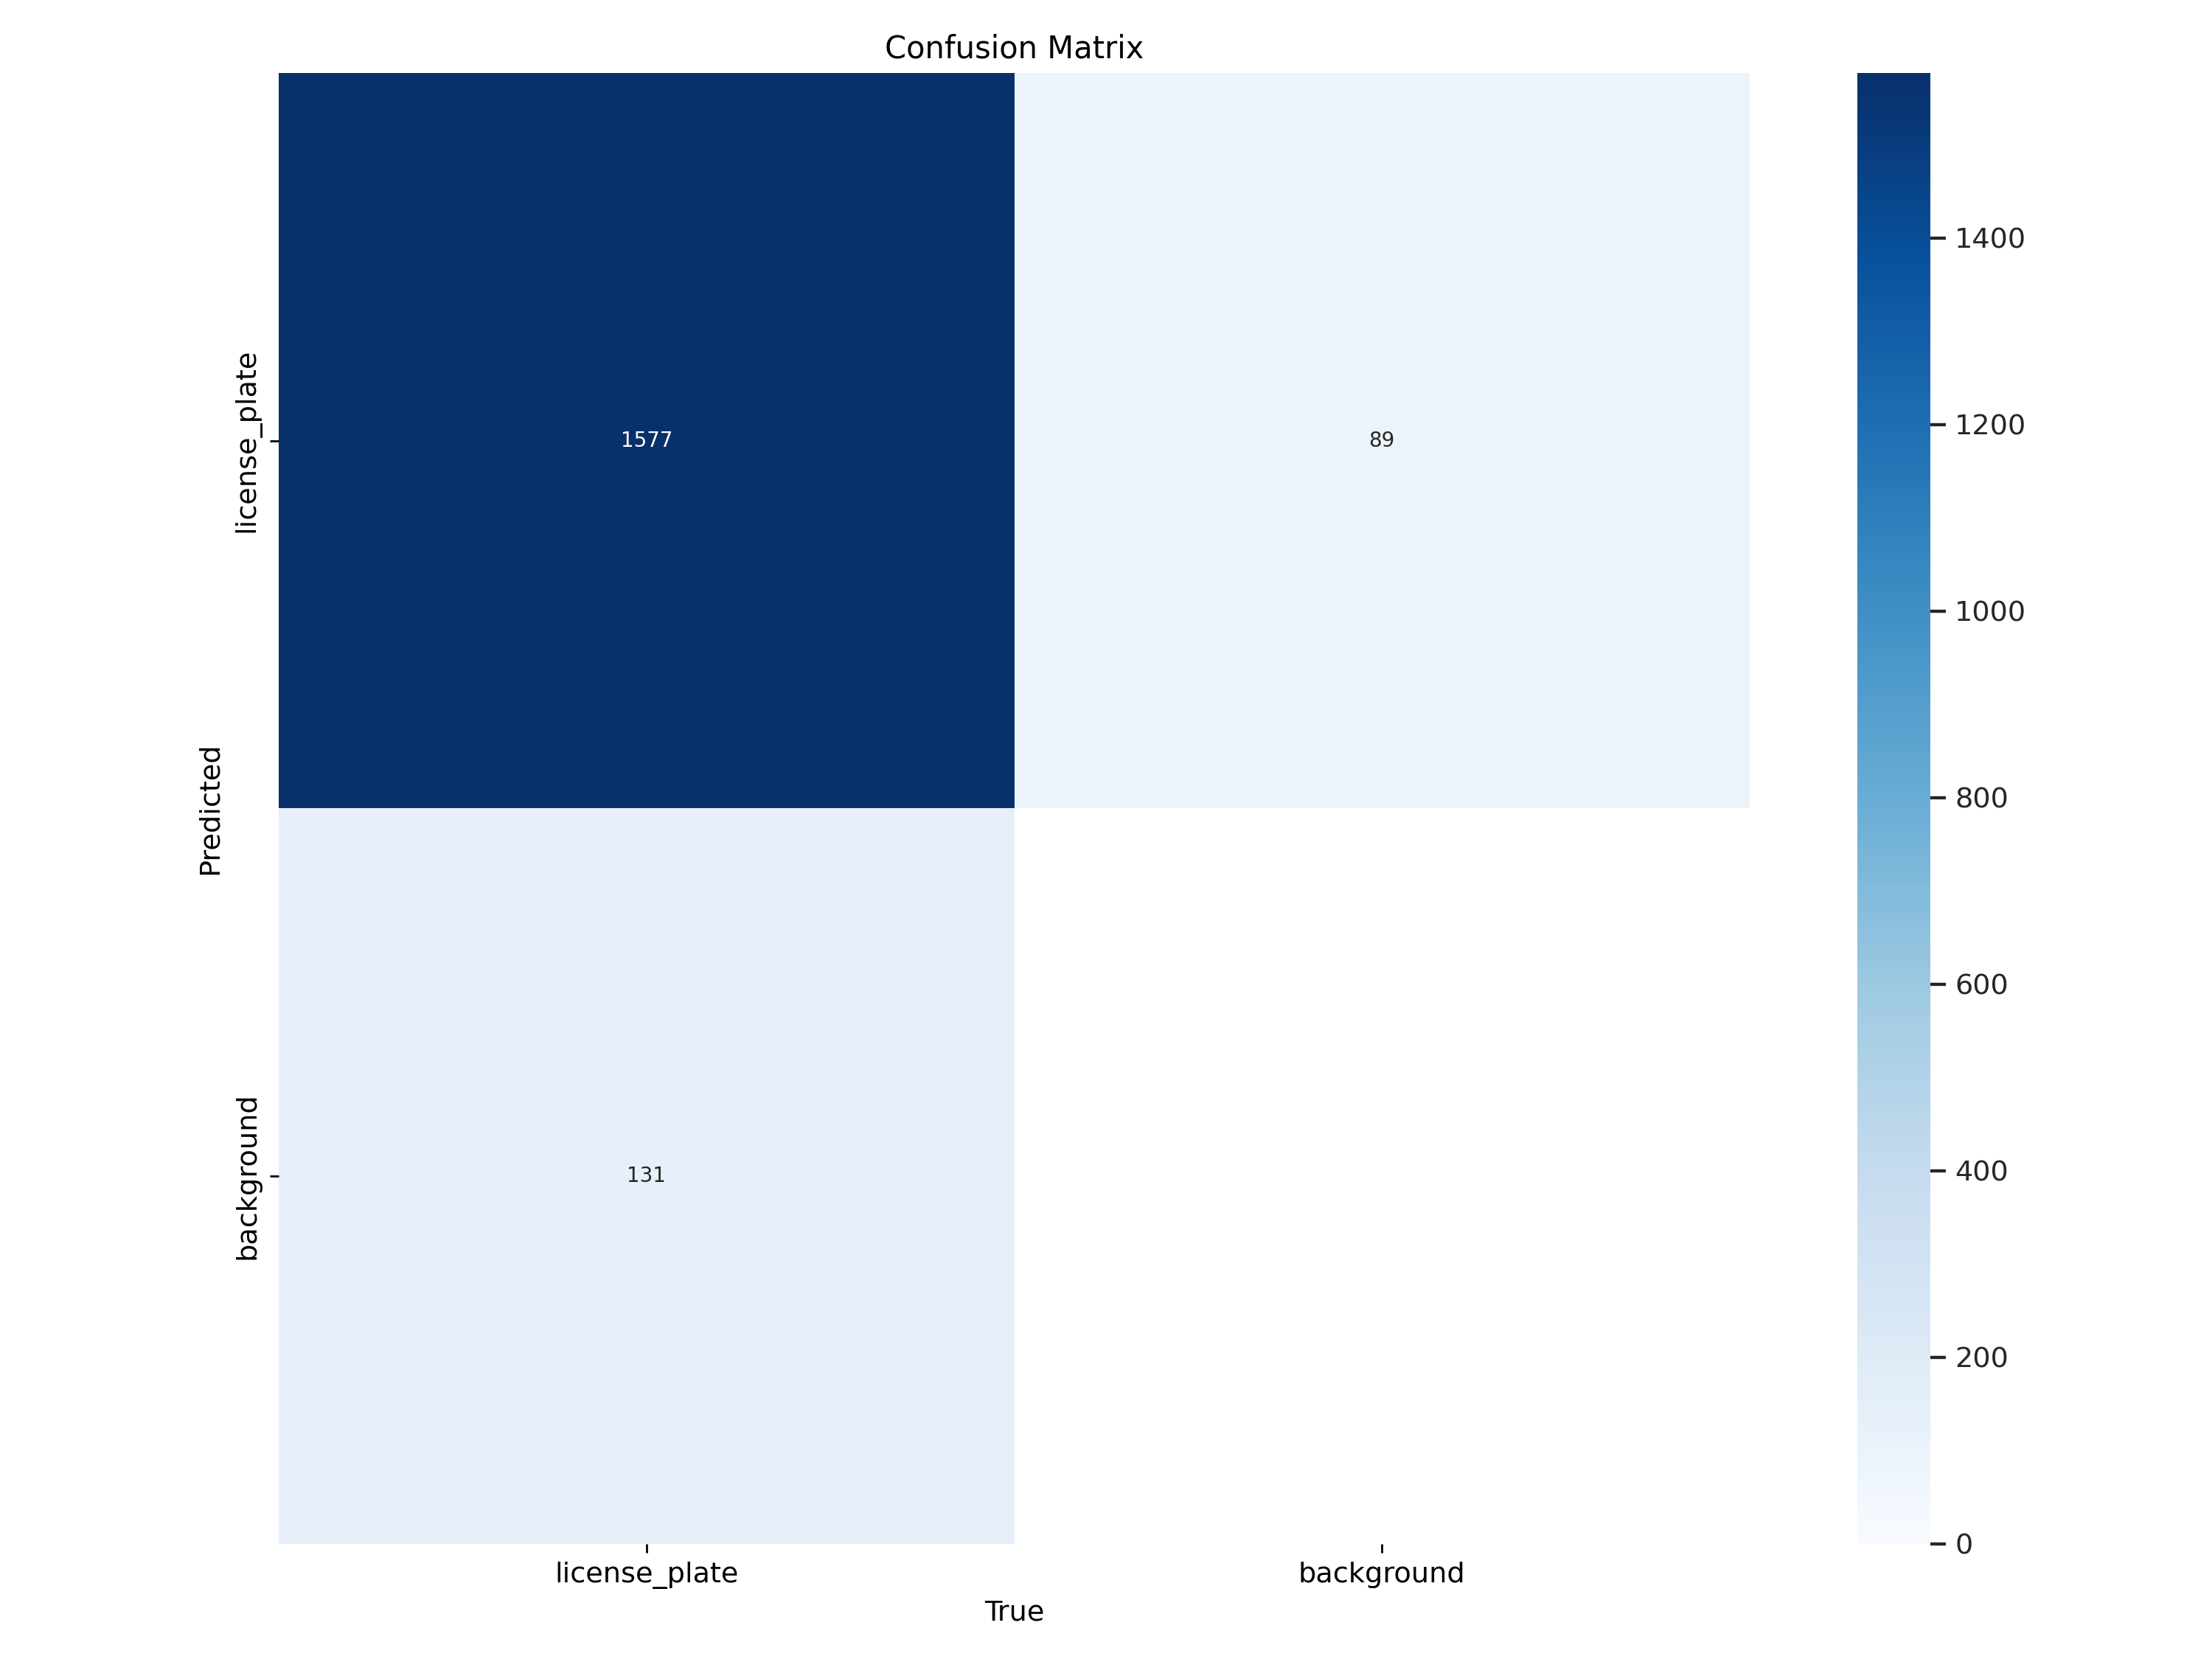

In [43]:
Image(filename="/content/drive/MyDrive/runs/detect/train/confusion_matrix.png",width=800)

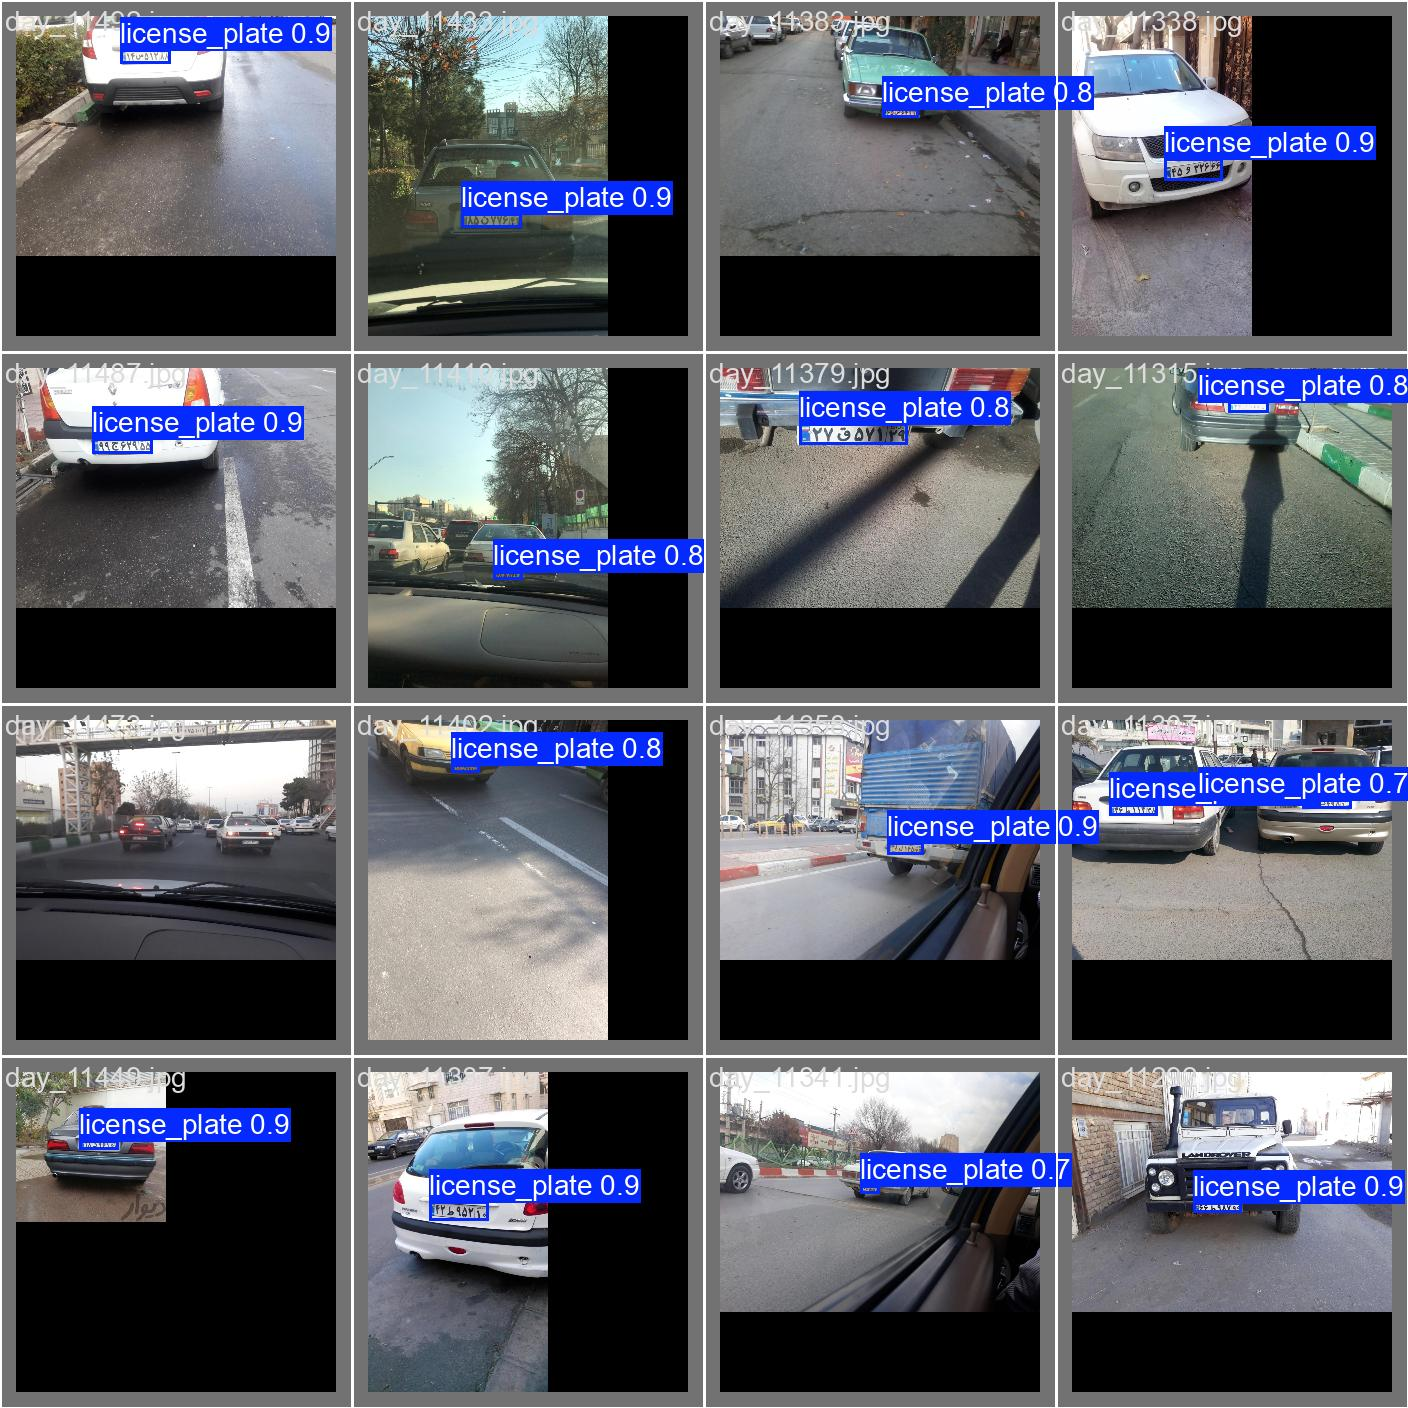

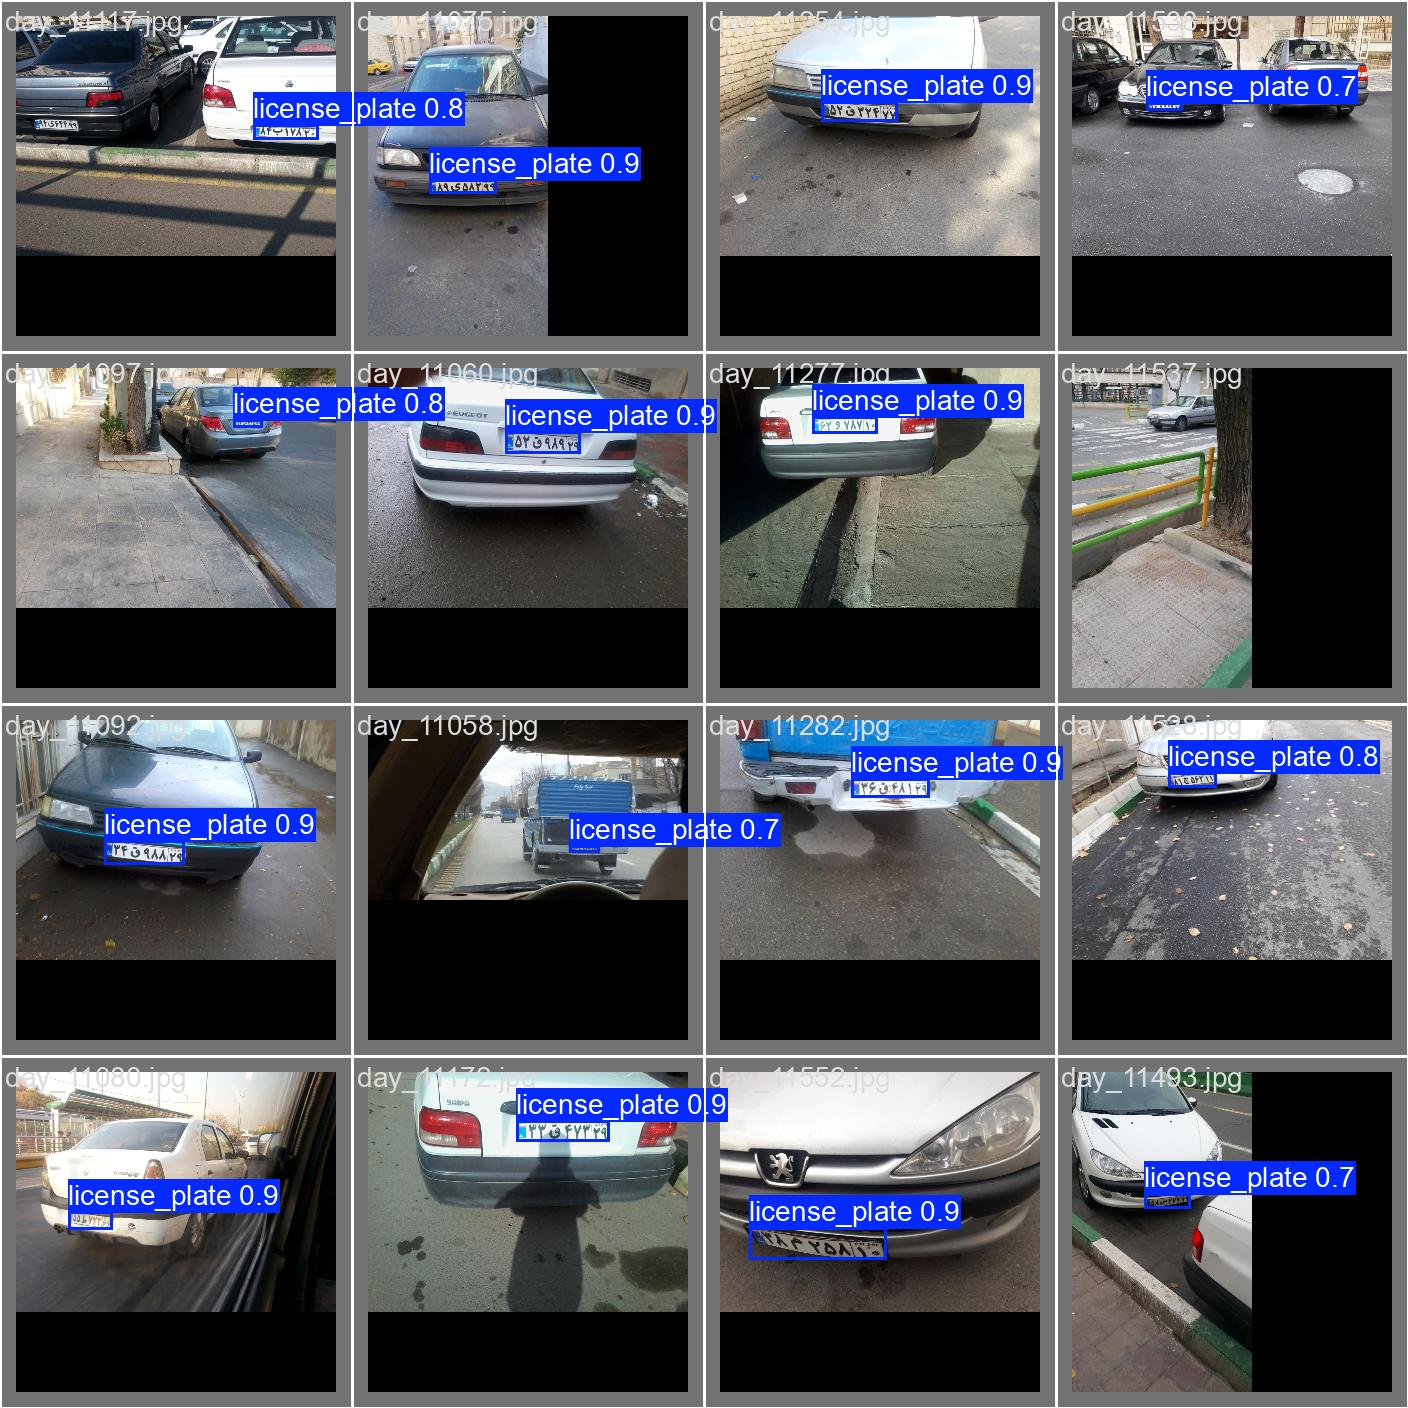

In [49]:
for image_path in glob.glob(f'/content/drive/MyDrive/runs/detect/val/val*pred.jpg'):
  display(Image(filename=image_path,width=800))
  print('\n')

###An Example of Covering the Plate

In [97]:
# Load your trained model
model = YOLO('/content/drive/MyDrive/runs/detect/train/weights/best.pt')

# # Function to blur a region of interest in an image
# def blur_region(img, x1, y1, x2, y2):
#     roi = img[y1:y2, x1:x2]
#     blurred_roi = cv2.GaussianBlur(roi, (31, 31), 0)
#     img[y1:y2, x1:x2] = blurred_roi
#     return img


In [117]:
def covering_plate(image_path):
  results = model(image_path)
  img = cv2.imread(image_path)
  # Draw bounding boxes
  for box in results[0].boxes:
      x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates

      # Draw bounding box on the original image

      # Draw rectangle
      cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), -1)


      # Prepare text

      text = 'Quera'
      box_width = x2 - x1
      box_height = y2 - y1

      # Set font scale relative to box height
      font_scale = box_height / 30
      thickness = int(box_height / 20)

      # Get text size to compute the center position
      text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]

      # Calculate text position to center within box
      text_x = x1 + (box_width - text_size[0]) // 2
      text_y = y1 + (box_height + text_size[1]) // 2

      # Put text inside the filled box
      cv2.putText(img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)

  output_image_path = f'{image_path[:-4]}'+'_covered.jpg'
  cv2.imwrite(output_image_path, img)
  plt.figure(figsize=(7,10))
  plt.imshow(plt.imread(output_image_path))
  plt.axis('off')



image 1/1 /content/validation_dataset/validation/day_00018.jpg: 320x256 1 license_plate, 60.2ms
Speed: 2.1ms preprocess, 60.2ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 256)


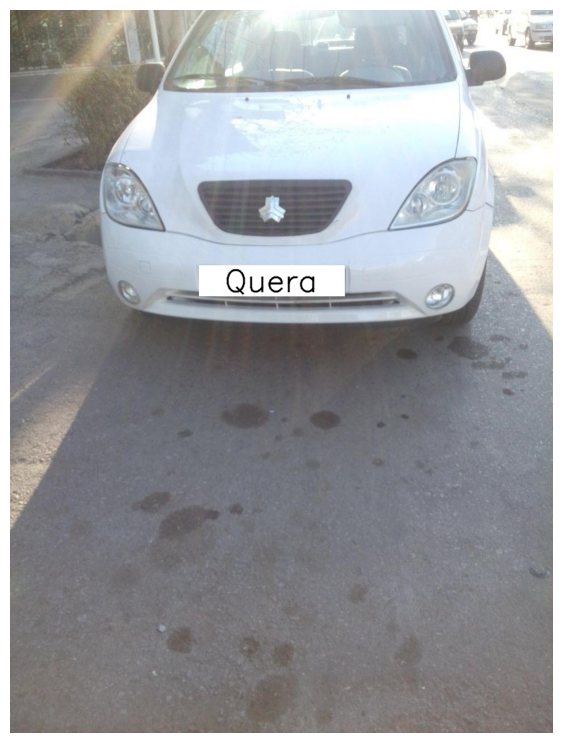

In [118]:
covering_plate('/content/validation_dataset/validation/day_00018.jpg')

###prediction

In [ ]:
# !yolo task=detect mode=predict model = /content/drive/MyDrive/runs/detect/train/weights/best.pt conf = 0.5 source = /content/data.yaml